## Quelques explications et détails

### But du modèle
Le modèle fait la classification des images en deux classes: poisson et plastique.

### Finalité
Étant donné la pollution grandissant dans les océans, les mers, les lacs due qux déchets plastique, ce modèle à été developpé pour être implémenté plus dans un robot qui sera chargé de nettoyer les eaux en recoltant les déchets plastiques (bouteilles, plastiques, etc).

### Outils utilisés
- Tensorflow
- TKinder
- Un dataset de poissons et un dataset de dechets plastiques

### Principe de fonctionnement
Le modèle reçoit une image, l'analyse et émet un résultat ie dit si c'est un poisson ou  un déchet plastique

### Difficultés rencontrés et perspectives

### Fiabilité du modèle

## Conception du modèle

### Librairies

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
print(tf.__version__)


2.8.0


### Checkup
We verify if we have the correct path
then we define directories for plastic and fishes folders
After, we see what the filenames look like in the `plastic` and `fishes` training directories
And also find out the total number of plastic and fishes images in the directories


In [4]:
#for showing the number of images on the directory
tf.keras.utils.image_dataset_from_directory(
   "fish-or-plastic"
)

Found 7156 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Vizualisation of some images of the dataset

In [5]:
# Directory with our training plastic pictures
train_plastic_dir = os.path.join("fish-or-plastic/plastic")

# Directory with our training fishes pictures
train_fish_dir = os.path.join("fish-or-plastic/fish")

In [6]:
train_plastic_names = os.listdir(train_plastic_dir)
print(train_plastic_names[:10])

train_fish_names = os.listdir(train_fish_dir)
print(train_fish_names[:10])

['0.27869600_1634897864_istock-1002940646-(1).jpg', '0e8e4084920de8c451770e67e946fd1b.jpg', '1.jpg', '10_jpg.rf.0f387beff9aa43e94e3eacada20a0063.jpg', '10_jpg.rf.1829a2896fb876b4498c821aa860220f.jpg', '10_jpg.rf.3f4f945e3eba5e91ef96df871380d17c.jpg', '10_jpg.rf.aeb8b24febdfe306e8d5ebe3898b0b5c.jpg', '10_jpg.rf.ba313adcbca98f1c105d068a540f3d97.jpg', '10_jpg.rf.cc6111f6257d48fdeec06e3c5b8a5804.jpg', '11_jpg.rf.0437003dfcc9166d49733755146bd9e2.jpg']
['1200px-Caranx_ignobilis.jpg', '17898641_101.jpg', '7cjy6br0i4_Medium_WW138750.jpg', 'cheilodactylus_ephippium_1.png', 'cheilodactylus_ephippium_2.png', 'cheilodactylus_ephippium_3.png', 'cheilodactylus_ephippium_4.png', 'cheilodactylus_fuscus_1.png', 'cheilodactylus_fuscus_2.png', 'cheilodactylus_fuscus_3.png']


In [7]:
print('total training plastic images:', len(os.listdir(train_plastic_dir)))
print('total training fish images:', len(os.listdir(train_fish_dir)))

total training plastic images: 3202
total training fish images: 3962


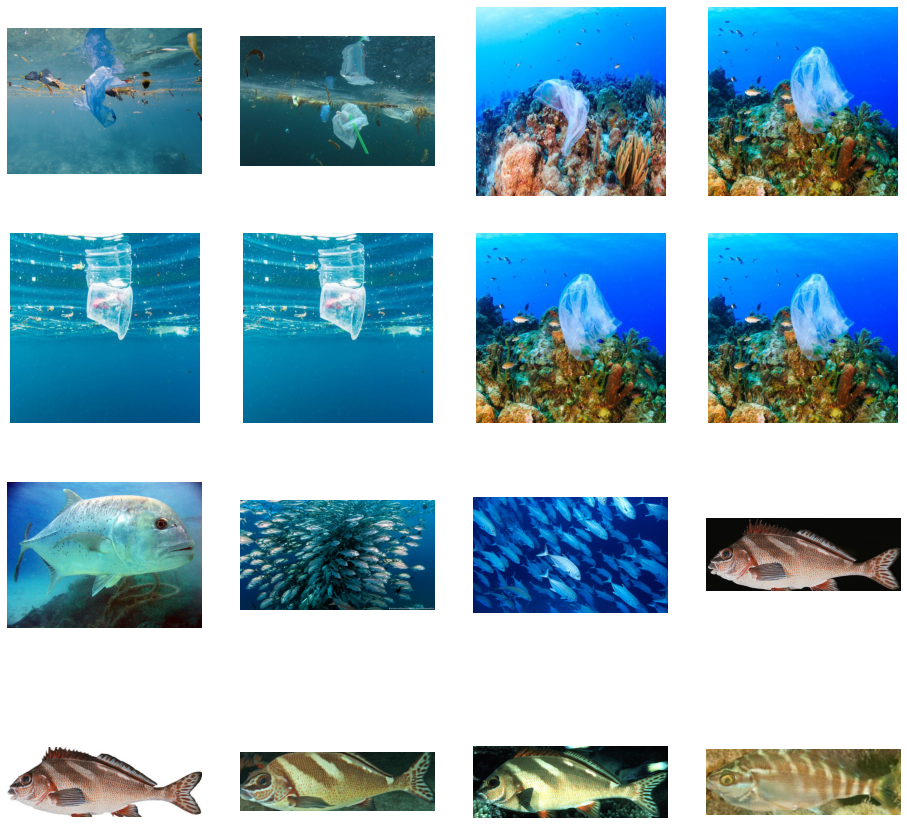

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_plastic_pix = [os.path.join(train_plastic_dir, fname) 
                for fname in train_plastic_names[pic_index-8:pic_index]]
next_fish_pix = [os.path.join(train_fish_dir, fname) 
                for fname in train_fish_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_plastic_pix+next_fish_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "fish-or-plastic",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(80, 80),
  batch_size=20)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "fish-or-plastic",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(80, 80),
  batch_size=20)

Found 7156 files belonging to 2 classes.
Using 5725 files for training.
Found 7156 files belonging to 2 classes.
Using 1431 files for validation.


### Creating a Callback class

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.975):

      # Stop if threshold is met
      print("\nAccuracy is about 97% so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

### Defining the model

In [11]:
#modele 2

num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(80, 80, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



### Compiling the model

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


### Training the model

In [24]:
"""model.fit(
  train_ds,
  validation_data=val_ds,
  steps_per_epoch=8,
  epochs=30
)"""

Epoch 1/30
8/8 [==============================] - 4s 472ms/step - loss: 0.0440 - accuracy: 0.9812 - val_loss: 0.0800 - val_accuracy: 0.9734
Epoch 2/30
8/8 [==============================] - 3s 464ms/step - loss: 0.0257 - accuracy: 0.9937 - val_loss: 0.0662 - val_accuracy: 0.9825
Epoch 3/30
8/8 [==============================] - 3s 443ms/step - loss: 0.0949 - accuracy: 0.9625 - val_loss: 0.0737 - val_accuracy: 0.9832
Epoch 4/30
8/8 [==============================] - 3s 459ms/step - loss: 0.0561 - accuracy: 0.9812 - val_loss: 0.0654 - val_accuracy: 0.9741
Epoch 5/30
8/8 [==============================] - 3s 460ms/step - loss: 0.0223 - accuracy: 0.9875 - val_loss: 0.0926 - val_accuracy: 0.9720
Epoch 6/30
8/8 [==============================] - 3s 455ms/step - loss: 0.0474 - accuracy: 0.9750 - val_loss: 0.1174 - val_accuracy: 0.9644
Epoch 7/30
8/8 [==============================] - 3s 456ms/step - loss: 0.0280 - accuracy: 0.9937 - val_loss: 0.0748 - val_accuracy: 0.9734
Epoch 8/30
8/8 [====

### Saving the model

In [26]:
# Save the entire model as a SavedModel.
"""!mkdir -p saved_model
model.save('saved_model/my_model')"""

INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9

### Chargement du modele

In [2]:
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9

### testing the model

In [5]:
class_names = train_ds.class_names
print(class_names)

['fish', 'plastic']


In [9]:
sunflower_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-rghii3pUoE07AGgGSyZfjyCKI7Msb5LbQ1SuMOseE_R6of8Gs5iBuuaTUB2JgFghAKI&usqp=CAU"
sunflower_path = tf.keras.utils.get_file('', origin=sunflower_url)

img = tf.keras.utils.load_img(
                                    sunflower_path, target_size=(80, 80)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor([0.9627048  0.03729517], shape=(2,), dtype=float32)
This image most likely belongs to fish with a 96.27 percent confidence.
